In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
print(tf.__version__)

2.6.0


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
batch_size = 32
img_height = 180
img_width = 180

In [4]:
ds_train=tf.keras.preprocessing.image_dataset_from_directory(
    'e-waste pictures/',
    labels='inferred',
    label_mode='int',
    class_names=['battery','controller','bulb','phone'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height,img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
)

Found 152 files belonging to 4 classes.
Using 122 files for training.


In [5]:
ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    'e-waste pictures/',
    labels='inferred',
    label_mode='int',
    class_names=['battery','controller','bulb','phone'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height,img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
)

Found 152 files belonging to 4 classes.
Using 30 files for validation.


In [6]:
class_names = np.array(ds_train.class_names)
print(class_names)

['battery' 'controller' 'bulb' 'phone']


In [7]:
for image_batch, labels_batch in ds_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


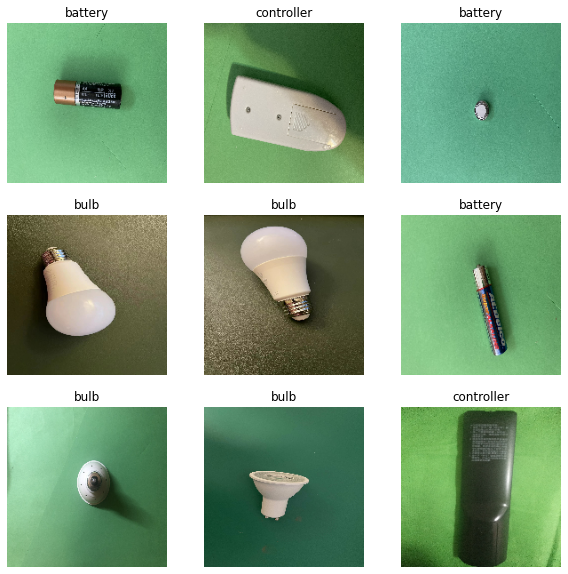

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(
        height_factor=(-0.5, 0),
        width_factor=(-0.5, 0)),

  ]
)

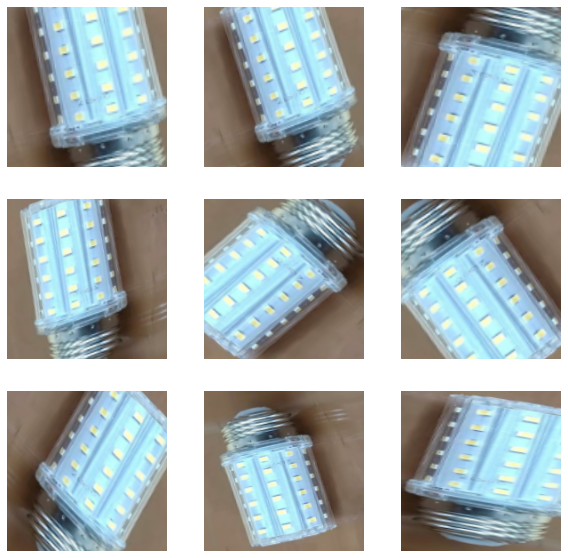

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in ds_train.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [12]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255,input_shape = (img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [15]:
epochs=50
history = model.fit(
  ds_train,
  validation_data=ds_val,
  epochs=epochs
)

Epoch 1/50
4/4 [==============================] - 3s 185ms/step - loss: 1.5170 - accuracy: 0.2213 - val_loss: 1.4544 - val_accuracy: 0.2333
Epoch 2/50
4/4 [==============================] - 0s 16ms/step - loss: 1.3705 - accuracy: 0.4344 - val_loss: 1.2216 - val_accuracy: 0.4667
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 1.2669 - accuracy: 0.4508 - val_loss: 1.2700 - val_accuracy: 0.3333
Epoch 4/50
4/4 [==============================] - 0s 16ms/step - loss: 1.1684 - accuracy: 0.5246 - val_loss: 1.5856 - val_accuracy: 0.2667
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 0.9933 - accuracy: 0.6393 - val_loss: 1.4783 - val_accuracy: 0.4667
Epoch 6/50
4/4 [==============================] - 0s 16ms/step - loss: 0.8444 - accuracy: 0.7131 - val_loss: 2.1565 - val_accuracy: 0.3667
Epoch 7/50
4/4 [==============================] - 0s 16ms/step - loss: 0.7042 - accuracy: 0.7377 - val_loss: 1.8370 - val_accuracy: 0.4667
Epoch 8/50
4/4 [==========

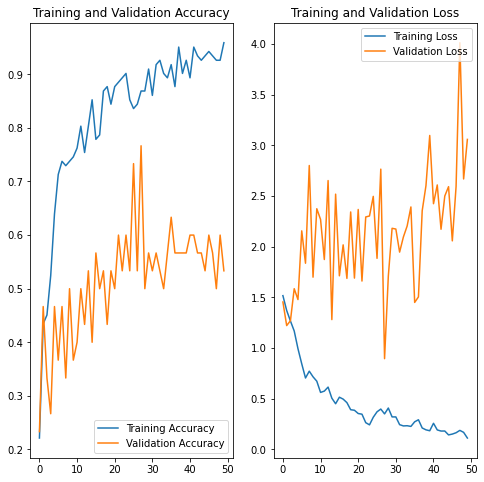

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
predicted_batch = model.predict(ds_val)
tf.math.argmax(predicted_batch, axis=-1)

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([0, 1, 2, 2, 1, 1, 1, 1, 0, 3, 2, 0, 1, 0, 3, 1, 1, 3, 1, 3, 1, 1,
       0, 1, 1, 2, 0, 3, 1, 0], dtype=int64)>

In [18]:
image_batch, label_batch = next(iter(ds_val))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['battery' 'controller' 'bulb' 'bulb' 'controller' 'controller'
 'controller' 'controller' 'battery' 'phone' 'bulb' 'battery' 'controller'
 'battery' 'phone' 'controller' 'controller' 'phone' 'controller' 'phone'
 'controller' 'controller' 'battery' 'controller' 'controller' 'bulb'
 'battery' 'phone' 'controller' 'battery']


In [19]:
true_class_names=class_names[label_batch]
true_class_names

array(['bulb', 'controller', 'bulb', 'phone', 'controller', 'bulb',
       'controller', 'bulb', 'bulb', 'phone', 'bulb', 'battery', 'bulb',
       'bulb', 'phone', 'controller', 'phone', 'phone', 'phone', 'phone',
       'controller', 'bulb', 'battery', 'phone', 'controller', 'bulb',
       'bulb', 'phone', 'phone', 'phone'], dtype='<U10')

In [20]:
print('True labels: ', label_batch)
print('Predicted labels: ', predicted_ids)

True labels:  [2 1 2 3 1 2 1 2 2 3 2 0 2 2 3 1 3 3 3 3 1 2 0 3 1 2 2 3 3 3]
Predicted labels:  [0 1 2 2 1 1 1 1 0 3 2 0 1 0 3 1 1 3 1 3 1 1 0 1 1 2 0 3 1 0]


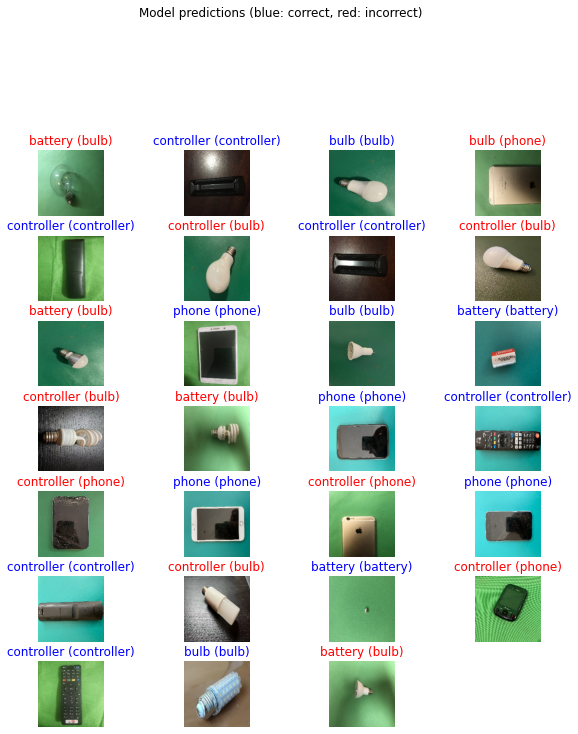

In [21]:
plt.figure(figsize=(10,20))
for n in range(27):
  plt.subplot(13,4,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n].astype("uint8"))
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title("{} ({})".format(predicted_class_names[n], true_class_names[n]), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [22]:
model.save('saved_model_zoom/my_model_zoom')

INFO:tensorflow:Assets written to: saved_model_zoom/my_model_zoom\assets


In [23]:
acc

[0.22131147980690002,
 0.4344262182712555,
 0.4508196711540222,
 0.5245901346206665,
 0.6393442749977112,
 0.7131147384643555,
 0.7377049326896667,
 0.7295082211494446,
 0.7377049326896667,
 0.7459016442298889,
 0.7622950673103333,
 0.8032786846160889,
 0.7540983557701111,
 0.8032786846160889,
 0.8524590134620667,
 0.7786885499954224,
 0.7868852615356445,
 0.868852436542511,
 0.8770492076873779,
 0.8442623019218445,
 0.8770492076873779,
 0.8852459192276001,
 0.8934426307678223,
 0.9016393423080444,
 0.8524590134620667,
 0.8360655903816223,
 0.8442623019218445,
 0.868852436542511,
 0.868852436542511,
 0.9098360538482666,
 0.8606557250022888,
 0.9180327653884888,
 0.9262295365333557,
 0.9016393423080444,
 0.8934426307678223,
 0.9180327653884888,
 0.8770492076873779,
 0.9508196711540222,
 0.9016393423080444,
 0.9262295365333557,
 0.8934426307678223,
 0.9508196711540222,
 0.9344262480735779,
 0.9262295365333557,
 0.9344262480735779,
 0.9426229596138,
 0.9344262480735779,
 0.926229536533355

In [24]:
val_acc

[0.23333333432674408,
 0.46666666865348816,
 0.3333333432674408,
 0.2666666805744171,
 0.46666666865348816,
 0.36666667461395264,
 0.46666666865348816,
 0.3333333432674408,
 0.5,
 0.36666667461395264,
 0.4000000059604645,
 0.5,
 0.4333333373069763,
 0.5333333611488342,
 0.4000000059604645,
 0.5666666626930237,
 0.5,
 0.5333333611488342,
 0.4333333373069763,
 0.5333333611488342,
 0.5,
 0.6000000238418579,
 0.5333333611488342,
 0.6000000238418579,
 0.5333333611488342,
 0.7333333492279053,
 0.5333333611488342,
 0.7666666507720947,
 0.5,
 0.5666666626930237,
 0.5333333611488342,
 0.5666666626930237,
 0.5333333611488342,
 0.5,
 0.5666666626930237,
 0.6333333253860474,
 0.5666666626930237,
 0.5666666626930237,
 0.5666666626930237,
 0.5666666626930237,
 0.6000000238418579,
 0.6000000238418579,
 0.5666666626930237,
 0.5666666626930237,
 0.5333333611488342,
 0.6000000238418579,
 0.5666666626930237,
 0.5,
 0.6000000238418579,
 0.5333333611488342]